# **5. Sentiment analysis using Transformer models.**

# Analyzing movie reviews using transformers

This problem asks you to train a sentiment analysis model using the BERT (Bidirectional Encoder Representations from Transformers) model, introduced [here](https://arxiv.org/abs/1810.04805). Specifically, we will parse movie reviews and classify their sentiment (according to whether they are positive or negative.)

We will use the [Huggingface transformers library](https://github.com/huggingface/transformers) to load a pre-trained BERT model to compute text embeddings, and append this with an RNN model to perform sentiment classification.

## Data preparation

Before delving into the model training, let's first do some basic data processing. The first challenge in NLP is to encode text into vector-style representations. This is done by a process called *tokenization*.

In [1]:
import torch
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Let us load the transformers library first.

In [2]:
!pip install transformers

Each transformer model is associated with a particular approach of tokenizing the input text.  We will use the `bert-base-uncased` model below, so let's examine its corresponding tokenizer.



In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The `tokenizer` has a `vocab` attribute which contains the actual vocabulary we will be using. First, let us discover how many tokens are in this language model by checking its length.

In [4]:
# Q1a: Print the size of the vocabulary of the above tokenizer.
print("Size:", tokenizer.vocab_size)

Size: 30522


Using the tokenizer is as simple as calling `tokenizer.tokenize` on a string. This will tokenize and lower case the data in a way that is consistent with the pre-trained transformer model.

In [5]:
tokens = tokenizer.tokenize('Hello WORLD how ARE yoU?')

print(tokens)

['hello', 'world', 'how', 'are', 'you', '?']


We can numericalize tokens using our vocabulary using `tokenizer.convert_tokens_to_ids`.

In [6]:
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

[7592, 2088, 2129, 2024, 2017, 1029]


The transformer was also trained with special tokens to mark the beginning and end of the sentence, as well as a standard padding and unknown token.

Let us declare them.

In [7]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


We can call a function to find the indices of the special tokens.

In [8]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


We can also find the maximum length of these input sizes by checking the `max_model_input_sizes` attribute (for this model, it is 512 tokens).

In [9]:
tokenizer.max_model_input_sizes.keys()

dict_keys(['google-bert/bert-base-uncased', 'google-bert/bert-large-uncased', 'google-bert/bert-base-cased', 'google-bert/bert-large-cased', 'google-bert/bert-base-multilingual-uncased', 'google-bert/bert-base-multilingual-cased', 'google-bert/bert-base-chinese', 'google-bert/bert-base-german-cased', 'google-bert/bert-large-uncased-whole-word-masking', 'google-bert/bert-large-cased-whole-word-masking', 'google-bert/bert-large-uncased-whole-word-masking-finetuned-squad', 'google-bert/bert-large-cased-whole-word-masking-finetuned-squad', 'google-bert/bert-base-cased-finetuned-mrpc', 'google-bert/bert-base-german-dbmdz-cased', 'google-bert/bert-base-german-dbmdz-uncased', 'TurkuNLP/bert-base-finnish-cased-v1', 'TurkuNLP/bert-base-finnish-uncased-v1', 'wietsedv/bert-base-dutch-cased'])

In [10]:
max_input_length = tokenizer.max_model_input_sizes['google-bert/bert-base-uncased']

In [11]:
max_input_length

512

Let us now define a function to tokenize any sentence, and cut length down to 510 tokens (we need one special `start` and `end` token for each sentence).

In [12]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

Finally, we are ready to load our dataset. We will use the [IMDB Moview Reviews](https://huggingface.co/datasets/imdb) dataset. Let us also split the train dataset to form a small validation set (to keep track of the best model).

In [13]:
!pip install -q torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 976.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 916.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [14]:
from torchtext import data, datasets
from torchtext.vocab import Vocab

In [15]:
TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [16]:
# from torchtext.legacy import data

# TEXT = data.Field(batch_first = True,
#                   use_vocab = False,
#                   tokenize = tokenize_and_cut,
#                   preprocessing = tokenizer.convert_tokens_to_ids,
#                   init_token = init_token_idx,
#                   eos_token = eos_token_idx,
#                   pad_token = pad_token_idx,
#                   unk_token = unk_token_idx)

# LABEL = data.LabelField(dtype = torch.float)

In [17]:
# from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:04<00:00, 20.7MB/s]


Let us examine the size of the train, validation, and test dataset.

In [18]:
# Q1b. Print the number of data points in the train, test, and validation sets.
print(len(train_data))
print(len(test_data))
print(len(valid_data))

17500
25000
7500


We will build a vocabulary for the labels using the `vocab.stoi` mapping.

In [19]:
LABEL.build_vocab(train_data)

In [20]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


Finally, we will set up the data-loader using a (large) batch size of 128. For text processing, we use the `BucketIterator` class.

In [21]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

## Model preparation

We will now load our pretrained BERT model. (Keep in mind that we should use the same model as the tokenizer that we chose above).

In [22]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

As mentioned above, we will append the BERT model with a bidirectional GRU to perform the classification.

In [23]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,bert,hidden_dim,output_dim,n_layers,bidirectional,dropout):

        super().__init__()

        self.bert = bert

        embedding_dim = bert.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)

        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]

        with torch.no_grad():
            embedded = self.bert(text)[0]

        #embedded = [batch size, sent len, emb dim]

        _, hidden = self.rnn(embedded)

        #hidden = [n layers * n directions, batch size, emb dim]

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        #hidden = [batch size, hid dim]

        output = self.out(hidden)

        #output = [batch size, out dim]

        return output

Next, we'll define our actual model.

Our model will consist of

* the BERT embedding (whose weights are frozen)
* a bidirectional GRU with 2 layers, with hidden dim 256 and dropout=0.25.
* a linear layer on top which does binary sentiment classification.

Let us create an instance of this model.

In [24]:
# Q2a: Instantiate the above model by setting the right hyperparameters.

# insert code here
class BERTGRUSentiment(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        self.bert = bert

        embedding_dim = bert.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          batch_first=True,
                          dropout=0 if n_layers < 2 else dropout)

        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text shape: [batch_size, max_len]

        with torch.no_grad():
            embedded = self.bert(text)[0]  # [batch_size, max_len, embedding_dim]

        _, hidden = self.rnn(embedded)  # [n_layers * num_directions, batch_size, hidden_dim]

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        output = self.out(hidden)  # [batch_size, output_dim]

        return output

HIDDEN_DIM    = 256
OUTPUT_DIM    = 1
N_LAYERS      = 2
BIDIRECTIONAL = True
DROPOUT       = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

We can check how many parameters the model has.

In [25]:
# Q2b: Print the number of trainable parameters in this model.

# insert code here.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

112241409


Oh no~ if you did this correctly, youy should see that this contains *112 million* parameters. Standard machines (or Colab) cannot handle such large models.

However, the majority of these parameters are from the BERT embedding, which we are not going to (re)train. In order to freeze certain parameters we can set their `requires_grad` attribute to `False`. To do this, we simply loop through all of the `named_parameters` in our model and if they're a part of the `bert` transformer model, we set `requires_grad = False`.

In [26]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [27]:
# Q2c: After freezing the BERT weights/biases, print the number of remaining trainable parameters.
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

print(count_parameters(model))

2759169


We should now see that our model has under 3M trainable parameters. Still not trivial but manageable.

## Train the Model

All this is now largely standard.

We will use:
* the Binary Cross Entropy loss function: `nn.BCEWithLogitsLoss()`
* the Adam optimizer

and run it for 2 epochs (that should be enough to start getting meaningful results).

In [28]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [29]:
criterion = nn.BCEWithLogitsLoss()

In [30]:
model = model.to(device)
criterion = criterion.to(device)


Also, define functions for:
* calculating accuracy.
* training for a single epoch, and reporting loss/accuracy.
* performing an evaluation epoch, and reporting loss/accuracy.
* calculating running times.

In [31]:
def binary_accuracy(preds, y):

    # Q3a. Compute accuracy (as a number between 0 and 1)
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [32]:
def train(model, iterator, optimizer, criterion):

    # Q3b. Set up the training function
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        batch_predictions = model(batch.text).squeeze(1)

        loss_per_batch = criterion(batch_predictions, batch.label)
        accuracy_per_batch = binary_accuracy(batch_predictions, batch.label)

        loss_per_batch.backward()
        optimizer.step()

        epoch_loss += loss_per_batch.item()
        epoch_acc += accuracy_per_batch.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
def evaluate(model, iterator, criterion):

    # Q3c. Set up the evaluation function.
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for batch in iterator:
            batch_predictions = model(batch.text).squeeze(1)

            loss_per_batch = criterion(batch_predictions, batch.label)
            accuracy_per_batch = binary_accuracy(batch_predictions, batch.label)

            epoch_loss += loss_per_batch.item()
            epoch_acc += accuracy_per_batch.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We are now ready to train our model.

**Statutory warning**: Training such models will take a very long time since this model is considerably larger than anything we have trained before. Even though we are not training any of the BERT parameters, we still have to make a forward pass. This will take time; each epoch may take upwards of 30 minutes on Colab.

Let us train for 2 epochs and print train loss/accuracy and validation loss/accuracy for each epoch. Let us also measure running time.

Saving intermediate model checkpoints using  

`torch.save(model.state_dict(),'model.pt')`

may be helpful with such large models.

In [35]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    # Q3d. Perform training/valudation by using the functions you defined earlier.

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 01 | Epoch Time: 13m 57s
	Train Loss: 0.486 | Train Acc: 75.59%
	 Val. Loss: 0.264 |  Val. Acc: 89.48%
Epoch: 02 | Epoch Time: 14m 13s
	Train Loss: 0.281 | Train Acc: 88.74%
	 Val. Loss: 0.227 |  Val. Acc: 91.11%


Load the best model parameters (measured in terms of validation loss) and evaluate the loss/accuracy on the test set.

In [36]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.226 | Test Acc: 91.18%


## Inference

We'll then use the model to test the sentiment of some fake movie reviews. We tokenize the input sentence, trim it down to length=510, add the special start and end tokens to either side, convert it to a `LongTensor`, add a fake batch dimension using `unsqueeze`, and perform inference using our model.

In [37]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [38]:
# Q4a. Perform sentiment analysis on the following two sentences.

predict_sentiment(model, tokenizer, "Justice League is terrible. I hated it.")

0.04586794599890709

In [39]:
predict_sentiment(model, tokenizer, "Avengers was great!!")

0.934116780757904

Great! Try playing around with two other movie reviews (you can grab some off the internet or make up text yourselves), and see whether your sentiment classifier is correctly capturing the mood of the review.

In [41]:
# Q4b. Perform sentiment analysis on two other movie review fragments of your choice.
review_text = "At the end of the day, I suppose that's money well spent. That being said, I am a huge fan of many DreamWorks franchises, including the first 3 KFP films, with the 3rd installment being the weakest of them, but still a good time."
predict_sentiment(model, tokenizer, review_text)

0.9269459843635559

In [42]:
# Let me remove the easy part 'At the end of the day, I suppose that's money well spent.'
review_text = "That being said, I am a huge fan of many DreamWorks franchises, including the first 3 KFP films, with the 3rd installment being the weakest of them, but still a good time."
predict_sentiment(model, tokenizer, review_text)

0.9269459843635559

Found this fun review of the controversial film Poor Things

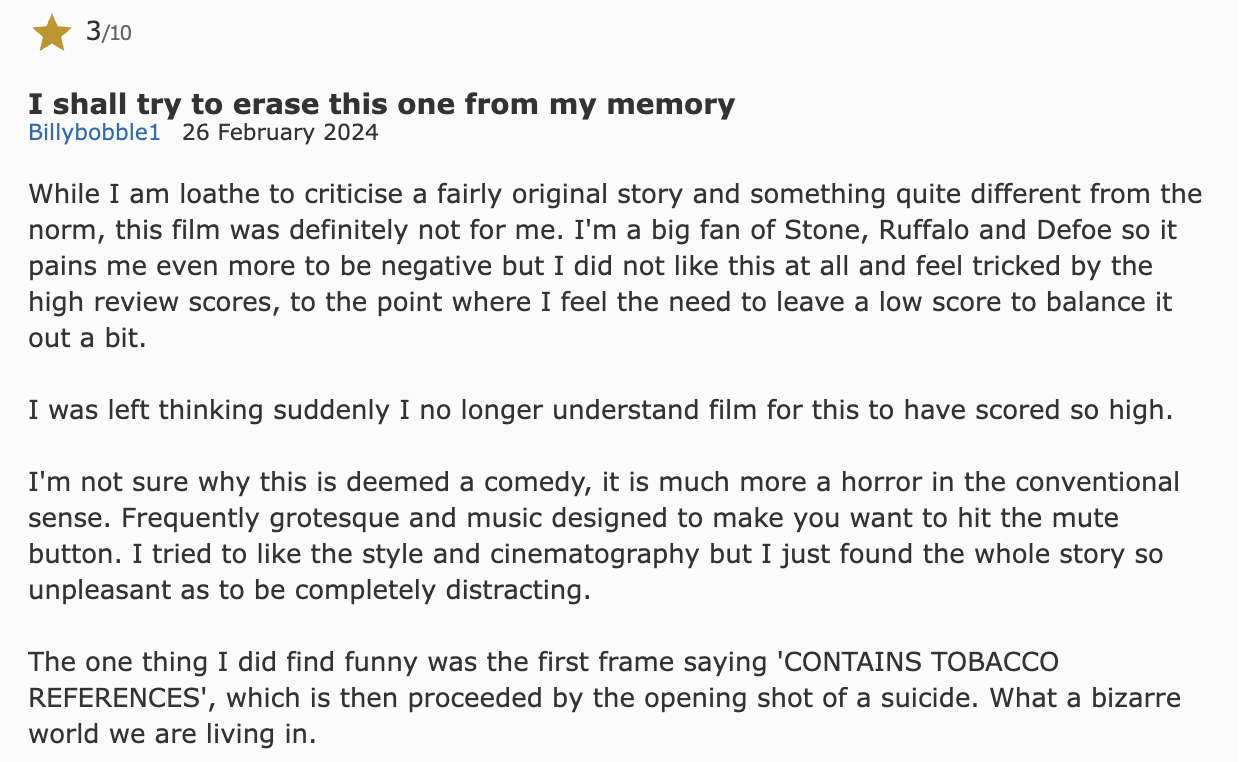

Let me try a few fun ones

In [44]:
review_text = "I was left thinking suddenly I no longer understand film for this to have scored so high."
predict_sentiment(model, tokenizer, review_text)

0.19604001939296722

In [45]:
review_text = "I'm not sure why this is deemed a comedy, it is much more a horror in the conventional sense."
predict_sentiment(model, tokenizer, review_text)

0.5154392719268799